In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import adabound
from sklearn.metrics import accuracy_score, roc_auc_score precision_recall_fscore_support
torch.cuda.is_available()

True

In [2]:
mydata = pd.read_csv('D:/Cho Lab Dropbox/연구과제별정리/02 목적과제_SPPEC_암종별(임상)_상희회준/위암/03 머신러닝_회준종혁다혜/01 Model/다혜/DL_data_220720.csv')

In [3]:
mydata = mydata[mydata['Age']>74]

In [4]:
event_data = mydata['Clavien_Dindo']
pd.crosstab(mydata['OP_year'], mydata['Clavien_Dindo'])

Clavien_Dindo,0,1,2
OP_year,,,
2014,62,7,5
2015,52,8,2
2016,53,7,5
2017,54,9,8
2018,41,8,8
2019,43,2,7
2020,53,18,8
2021,25,24,12


In [5]:
pre_op_dat = mydata[['Sex', 
        'Age',
        'ASA_Score',
        'Smoking',
        'Drinking',
        'BMI',
        'Hypertension',
        'Diabetes',
        'Ass_condition_grp',
        'Ass_lesion',
        'Clinical_Stage_grp ',
        'Histology',
        'Lauren',
        'Reconstruction',
        'Combined_Resection',
        'Platelets',
        'Albumin',
        'Cell_Count',
        'Hemoglobin_status',
        'Neutrophil_count_status'
]]

post_op_dat = mydata[['fStage_grp',
                'Location',
                'LN_Dissection',
                'Operation',
                'Intraop_cc',
                'OP_time',
                'EBL'
                ]]

In [6]:
nsubject = mydata.shape[0]

In [7]:
contvar = ['Age', "Platelets", "Albumin", "Cell_Count"]
catevar= pre_op_dat.columns[[x not in contvar for x in pre_op_dat.columns]]

contvar_post = ['OP_time', 'EBL']
catevar_post = post_op_dat.columns[[x not in contvar_post for x in post_op_dat.columns]]

In [8]:
pre_op_dat2 = pre_op_dat.copy()
pre_op_dat2[catevar] = pre_op_dat2[catevar].astype("category")

post_op_dat2 = post_op_dat.copy()
post_op_dat2[catevar_post] = post_op_dat2[catevar_post].astype("category")

print(pre_op_dat2.dtypes, post_op_dat2.dtypes)

Sex                        category
Age                           int64
ASA_Score                  category
Smoking                    category
Drinking                   category
BMI                        category
Hypertension               category
Diabetes                   category
Ass_condition_grp          category
Ass_lesion                 category
Clinical_Stage_grp         category
Histology                  category
Lauren                     category
Reconstruction             category
Combined_Resection         category
Platelets                     int64
Albumin                     float64
Cell_Count                  float64
Hemoglobin_status          category
Neutrophil_count_status    category
dtype: object fStage_grp       category
Location         category
LN_Dissection    category
Operation        category
Intraop_cc       category
OP_time             int64
EBL               float64
dtype: object


In [9]:
pre_op_dat3 = pd.get_dummies(pre_op_dat2, columns=catevar)
pre_dat = pre_op_dat3.to_numpy()

post_op_dat3 = pd.get_dummies(post_op_dat2, columns=catevar_post)

In [10]:
pre_op_dat3.shape

(521, 45)

In [11]:
pre_op_dat3

,Age,Platelets,Albumin,Cell_Count,Sex_F,Sex_M,ASA_Score_1,ASA_Score_2,Smoking_no,Smoking_yes,...,Reconstruction_1 BI,Reconstruction_2 BII,Reconstruction_3 Roux-en-Y,Reconstruction_4 Others,Combined_Resection_No,Combined_Resection_Yes,Hemoglobin_status_1. Normal,Hemoglobin_status_2. Abnormal,Neutrophil_count_status_1. Normal,Neutrophil_count_status_2. Abnormal
16,76,187,4.5,166.940,0,1,1,0,1,0,...,0,0,0,1,1,0,1,0,1,0
21,80,299,3.8,237.958,1,0,1,0,1,0,...,0,0,1,0,1,0,1,0,1,0
42,76,197,3.8,165.851,0,1,1,0,1,0,...,0,1,0,0,1,0,1,0,1,0
56,75,223,4.8,105.984,1,0,1,0,1,0,...,0,0,0,1,1,0,1,0,1,0
58,79,241,4.8,292.024,0,1,1,0,0,1,...,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3500,77,180,4.3,130.277,0,1,1,0,1,0,...,0,1,0,0,1,0,1,0,1,0
3508,82,234,4.3,179.278,1,0,1,0,1,0,...,0,1,0,0,1,0,1,0,1,0
3523,78,128,4.3,167.862,0,1,0,1,1,0,...,1,0,0,0,1,0,1,0,1,0
3525,77,188,4.3,120.124,0,1,0,1,1,0,...,0,1,0,0,1,0,0,1,1,0


In [12]:
pre_op_dat3.isnull().sum()

Age                                                     0
Platelets                                               0
Albumin                                                 0
Cell_Count                                              0
Sex_F                                                   0
Sex_M                                                   0
ASA_Score_1                                             0
ASA_Score_2                                             0
Smoking_no                                              0
Smoking_yes                                             0
Drinking_no                                             0
Drinking_yes                                            0
BMI_1 <18.5                                             0
BMI_2 18.5-24.9                                         0
BMI_3 >25                                               0
Hypertension_no                                         0
Hypertension_yes                                        0
Diabetes_no   

In [13]:
post_op_dat3.isnull().sum()

OP_time                          0
EBL                              0
fStage_grp_1.0                   0
fStage_grp_2.0                   0
Location_1 Lower                 0
Location_2 Middle                0
Location_3 Upper                 0
Location_4 Others                0
LN_Dissection_1. D1              0
LN_Dissection_2. D2              0
Operation_Partial Gastractomy    0
Operation_Total Gastractomy      0
Intraop_cc_No                    0
Intraop_cc_Yes                   0
dtype: int64

In [14]:
post_op_dat3

,OP_time,EBL,fStage_grp_1.0,fStage_grp_2.0,Location_1 Lower,Location_2 Middle,Location_3 Upper,Location_4 Others,LN_Dissection_1. D1,LN_Dissection_2. D2,Operation_Partial Gastractomy,Operation_Total Gastractomy,Intraop_cc_No,Intraop_cc_Yes
16,160,100.0,1,0,0,0,1,0,1,0,1,0,1,0
21,145,50.0,1,0,0,0,1,0,0,1,0,1,1,0
42,210,0.0,1,0,1,0,0,0,0,1,1,0,1,0
56,145,200.0,1,0,0,1,0,0,1,0,1,0,1,0
58,130,0.0,0,1,0,1,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3500,155,400.0,0,1,1,0,0,0,0,1,1,0,1,0
3508,155,5.0,1,0,1,0,0,0,0,1,1,0,1,0
3523,195,20.0,1,0,1,0,0,0,1,0,1,0,1,0
3525,140,50.0,1,0,1,0,0,0,1,0,1,0,1,0


In [15]:
#missing_col = ['Z_EBL']
#Technique 1: Using mean to impute the missing values
#for i in missing_col:
#    post_op_dat3.loc[post_op_dat3.loc[:,i].isnull(),i]=0

In [16]:
post_dat = post_op_dat3.to_numpy()

In [17]:
total_dat = np.concatenate([pre_dat, post_dat], 1)
print(pre_dat.shape, post_dat.shape, total_dat.shape)

(521, 45) (521, 14) (521, 59)


In [18]:
OP_year = mydata['OP_year']
testindex = np.isin(OP_year, [2020, 2021])
#testindex = np.isin(OP_year, [2015, 2017, 2019, 2021])

In [19]:
total_train = total_dat[np.invert(testindex)].copy()
event_train = event_data.values[np.invert(testindex)].copy()

total_test = total_dat[testindex].copy()
event_test = event_data.values[testindex].copy()

ntrain = total_train.shape[0]
nsubject, ntrain, nsubject-ntrain

(521, 381, 140)

In [20]:
cont_index = [1, 2, 3, 49, 50]

In [21]:
total_dat[:, cont_index]

array([[187.   ,   4.5  , 166.94 ,   0.   ,   0.   ],
       [299.   ,   3.8  , 237.958,   0.   ,   0.   ],
       [197.   ,   3.8  , 165.851,   1.   ,   0.   ],
       ...,
       [128.   ,   4.3  , 167.862,   1.   ,   0.   ],
       [188.   ,   4.3  , 120.124,   1.   ,   0.   ],
       [284.   ,   4.3  , 215.441,   0.   ,   0.   ]])

In [22]:
train_max = total_train[:, cont_index].max(0, keepdims=True)

In [23]:
train_max

array([[814.  ,   5.3 , 486.04,   1.  ,   1.  ]])

In [24]:
total_train[:, cont_index] = total_train[:, cont_index]/train_max

In [25]:
test_max = total_test[:, cont_index].max(0, keepdims=True)
test_max

array([[453.  ,   4.7 , 449.92,   1.  ,   1.  ]])

In [26]:
total_test[:, cont_index] = total_test[:, cont_index]/test_max

In [27]:
event_train

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 1, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 1, 1, 0, 1, 0, 0, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 2,

In [28]:
num_event = 2
batch_size = 256
hidden_size = 256

train_data = []
for i in range(ntrain):
    train_data.append([total_train[i], event_train[i]])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
train_loader

In [29]:
cuda = torch.cuda.is_available() # False
if cuda:
    device = 'cuda:0'
else:
    device = 'cpu'

In [30]:
class MLP(nn.Module):
    
    def __init__(self, input_size, hidden_size=128, num_layer=1, num_event=1):
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.num_event = num_event
        
        self.hidden_in = nn.Linear(self.input_size, self.hidden_size)
        hiddens = [
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
        ]
        self.hiddens = nn.Sequential(*((num_layer-1)*hiddens))
        self.hidden_out = nn.Linear(self.hidden_size, self.num_event+1)
        self.activation = nn.LeakyReLU(inplace=True)
                
    def forward(self, x):
        ## x: (batch, input_size)

        batch_size = x.shape[0]
        x = self.hidden_in(x)
        x = self.hiddens(self.activation(x))
        x = self.hidden_out(x)
        
        return x

In [31]:
model = MLP(input_size=41, hidden_size=128, num_layer=2, num_event=num_event).to(device)
model

MLP(
  (hidden_in): Linear(in_features=41, out_features=128, bias=True)
  (hiddens): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (hidden_out): Linear(in_features=128, out_features=3, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
)

/75+_test2021_ebl0/MultiMLP_16hiddensize_1layers_1e-03


C:\Users\demel\anaconda3\envs\pytorch\lib\site-packages\adabound\adabound.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch: 0, Loss: 8.0942e+00
Epoch: 100, Loss: 6.0666e-01
Epoch: 200, Loss: 5.9152e-01
Epoch: 300, Loss: 5.8632e-01
Epoch: 400, Loss: 6.0671e-01
Epoch: 500, Loss: 6.2704e-01
Epoch: 600, Loss: 5.9296e-01
Epoch: 700, Loss: 6.3537e-01
Epoch: 800, Loss: 6.1219e-01
Epoch: 900, Loss: 6.0051e-01
Epoch: 1000, Loss: 6.1910e-01
Epoch: 1100, Loss: 5.8532e-01
Epoch: 1200, Loss: 5.6120e-01
Epoch: 1300, Loss: 5.9351e-01
Epoch: 1400, Loss: 5.9662e-01
Epoch: 1500, Loss: 6.0443e-01
Epoch: 1600, Loss: 5.9147e-01
Epoch: 1700, Loss: 5.6790e-01
Epoch: 1800, Loss: 5.6200e-01
Epoch: 1900, Loss: 5.9048e-01
Epoch: 2000, Loss: 5.9418e-01
Epoch: 2100, Loss: 6.1479e-01
Epoch: 2200, Loss: 5.8405e-01


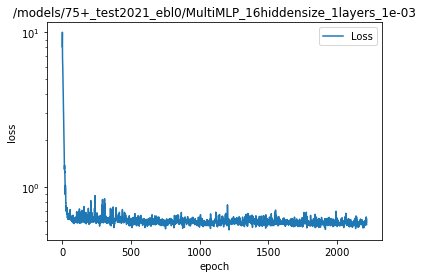

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_16hiddensize_1layers_1e-03
Train accuracy = 0.8058, Test accuracy = 0.5571
Event: Mild; Train AUC = 0.5968, Test AUC = 0.5641
Event: Severe, death; Train AUC = 0.7915, Test AUC = 0.5787
/75+_test2021_ebl0/MultiMLP_16hiddensize_2layers_1e-03
Epoch: 0, Loss: 2.1010e+00
Epoch: 100, Loss: 6.1886e-01
Epoch: 200, Loss: 5.9062e-01
Epoch: 300, Loss: 5.7665e-01
Epoch: 400, Loss: 6.0989e-01
Epoch: 500, Loss: 6.1994e-01
Epoch: 600, Loss: 5.7530e-01
Epoch: 700, Loss: 5.8074e-01
Epoch: 800, Loss: 5.8441e-01
Epoch: 900, Loss: 5.6903e-01
Epoch: 1000, Loss: 5.8536e-01
Epoch: 1100, Loss: 5.4371e-01
Epoch: 1200, Loss: 5.8918e-01
Epoch: 1300, Loss: 5.8100e-01
Epoch: 1400, Loss: 5.8138e-01
Epoch: 1500, Loss: 5.7578e-01
Epoch: 1600, Loss: 5.6135e-01
Epoch: 1700, Loss: 5.5070e-01
Epoch: 1800, Loss: 5.5546e-01
Epoch: 1900, Loss: 5.6047e-01
Epoch: 2000, Loss: 5.5420e-01
Epoch: 2100, Loss: 5.3783e-01
Epoch: 2200, Loss: 5.5141e-

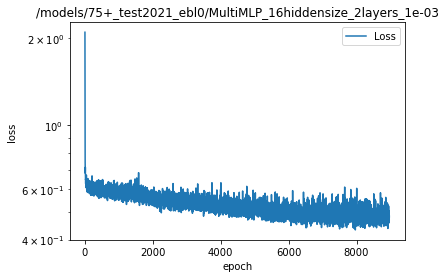

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_16hiddensize_2layers_1e-03
Train accuracy = 0.8241, Test accuracy = 0.5571
Event: Mild; Train AUC = 0.8153, Test AUC = 0.5155
Event: Severe, death; Train AUC = 0.8704, Test AUC = 0.4871
/75+_test2021_ebl0/MultiMLP_16hiddensize_3layers_1e-03
Epoch: 0, Loss: 1.9766e+00
Epoch: 100, Loss: 6.1471e-01
Epoch: 200, Loss: 5.9807e-01
Epoch: 300, Loss: 5.9095e-01
Epoch: 400, Loss: 5.7596e-01
Epoch: 500, Loss: 5.5624e-01
Epoch: 600, Loss: 5.7855e-01
Epoch: 700, Loss: 5.7114e-01
Epoch: 800, Loss: 5.7564e-01
Epoch: 900, Loss: 5.5312e-01
Epoch: 1000, Loss: 6.1083e-01
Epoch: 1100, Loss: 5.3154e-01
Epoch: 1200, Loss: 5.3582e-01
Epoch: 1300, Loss: 5.7662e-01
Epoch: 1400, Loss: 5.0434e-01
Epoch: 1500, Loss: 5.2457e-01
Epoch: 1600, Loss: 5.3476e-01
Epoch: 1700, Loss: 5.5414e-01
Epoch: 1800, Loss: 5.1496e-01
Epoch: 1900, Loss: 5.0796e-01
Epoch: 2000, Loss: 5.2406e-01
Epoch: 2100, Loss: 5.0211e-01
Epoch: 2200, Loss: 5.0843e-

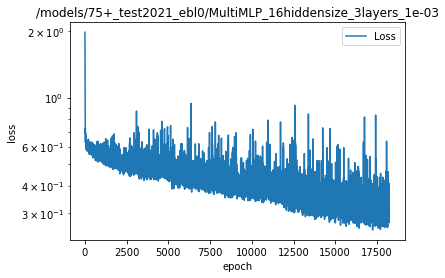

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_16hiddensize_3layers_1e-03
Train accuracy = 0.8740, Test accuracy = 0.5286
Event: Mild; Train AUC = 0.9455, Test AUC = 0.4708
Event: Severe, death; Train AUC = 0.9559, Test AUC = 0.4183
/75+_test2021_ebl0/MultiMLP_32hiddensize_1layers_1e-03
Epoch: 0, Loss: 3.8876e+00
Epoch: 100, Loss: 6.5400e-01
Epoch: 200, Loss: 5.5684e-01
Epoch: 300, Loss: 5.9871e-01
Epoch: 400, Loss: 5.8843e-01
Epoch: 500, Loss: 5.8697e-01
Epoch: 600, Loss: 5.7380e-01
Epoch: 700, Loss: 6.6262e-01
Epoch: 800, Loss: 5.8007e-01
Epoch: 900, Loss: 5.7956e-01
Epoch: 1000, Loss: 6.0006e-01
Epoch: 1100, Loss: 5.7065e-01
Epoch: 1200, Loss: 5.9514e-01
Epoch: 1300, Loss: 5.6914e-01
Epoch: 1400, Loss: 5.6863e-01
Epoch: 1500, Loss: 5.8573e-01
Epoch: 1600, Loss: 5.8229e-01
Epoch: 1700, Loss: 6.1037e-01
Epoch: 1800, Loss: 5.7068e-01
Epoch: 1900, Loss: 6.1378e-01
Epoch: 2000, Loss: 5.9498e-01
Epoch: 2100, Loss: 5.3267e-01
Epoch: 2200, Loss: 6.5454e-

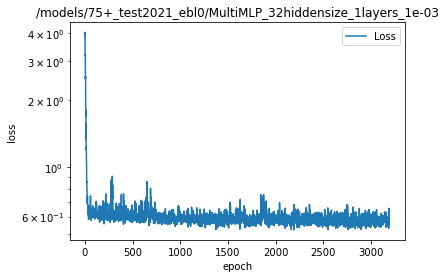

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_32hiddensize_1layers_1e-03
Train accuracy = 0.8005, Test accuracy = 0.5571
Event: Mild; Train AUC = 0.6531, Test AUC = 0.4721
Event: Severe, death; Train AUC = 0.7190, Test AUC = 0.5567
/75+_test2021_ebl0/MultiMLP_32hiddensize_2layers_1e-03
Epoch: 0, Loss: 1.4223e+00
Epoch: 100, Loss: 5.8986e-01
Epoch: 200, Loss: 6.1923e-01
Epoch: 300, Loss: 5.4762e-01
Epoch: 400, Loss: 5.6574e-01
Epoch: 500, Loss: 5.6307e-01
Epoch: 600, Loss: 5.9513e-01
Epoch: 700, Loss: 5.4832e-01
Epoch: 800, Loss: 5.8574e-01
Epoch: 900, Loss: 5.3848e-01
Epoch: 1000, Loss: 5.3942e-01
Epoch: 1100, Loss: 5.6811e-01
Epoch: 1200, Loss: 5.4082e-01
Epoch: 1300, Loss: 5.7847e-01
Epoch: 1400, Loss: 5.5802e-01
Epoch: 1500, Loss: 5.2939e-01
Epoch: 1600, Loss: 5.3398e-01
Epoch: 1700, Loss: 5.3297e-01
Epoch: 1800, Loss: 5.3942e-01
Epoch: 1900, Loss: 5.1947e-01
Epoch: 2000, Loss: 5.1851e-01
Epoch: 2100, Loss: 5.1880e-01
Epoch: 2200, Loss: 5.0940e-

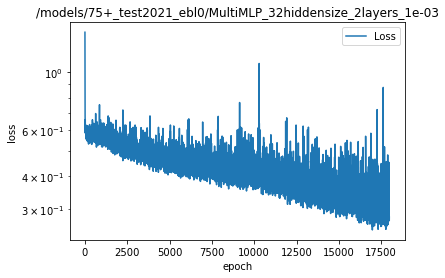

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_32hiddensize_2layers_1e-03
Train accuracy = 0.8661, Test accuracy = 0.5571
Event: Mild; Train AUC = 0.9449, Test AUC = 0.5100
Event: Severe, death; Train AUC = 0.9634, Test AUC = 0.5042
/75+_test2021_ebl0/MultiMLP_32hiddensize_3layers_1e-03
Epoch: 0, Loss: 2.2903e+00
Epoch: 100, Loss: 5.8110e-01
Epoch: 200, Loss: 6.0878e-01
Epoch: 300, Loss: 5.8772e-01
Epoch: 400, Loss: 5.7180e-01
Epoch: 500, Loss: 6.0452e-01
Epoch: 600, Loss: 5.8181e-01
Epoch: 700, Loss: 5.7672e-01
Epoch: 800, Loss: 5.7139e-01
Epoch: 900, Loss: 5.7127e-01
Epoch: 1000, Loss: 5.6968e-01
Epoch: 1100, Loss: 5.6984e-01
Epoch: 1200, Loss: 5.6800e-01
Epoch: 1300, Loss: 5.5984e-01
Epoch: 1400, Loss: 5.6697e-01
Epoch: 1500, Loss: 5.6581e-01
Epoch: 1600, Loss: 5.7334e-01
Epoch: 1700, Loss: 5.2722e-01
Epoch: 1800, Loss: 5.3266e-01
Epoch: 1900, Loss: 5.3628e-01
Epoch: 2000, Loss: 5.8175e-01
Epoch: 2100, Loss: 4.9950e-01
Epoch: 2200, Loss: 5.5124e-

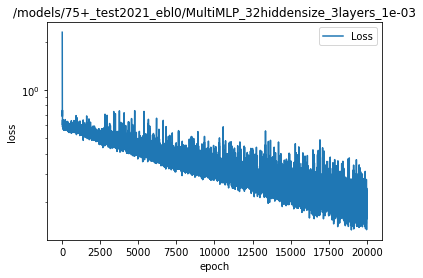

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_32hiddensize_3layers_1e-03
Train accuracy = 0.9396, Test accuracy = 0.4929
Event: Mild; Train AUC = 0.9870, Test AUC = 0.5583
Event: Severe, death; Train AUC = 0.9950, Test AUC = 0.4117
/75+_test2021_ebl0/MultiMLP_64hiddensize_1layers_1e-03
Epoch: 0, Loss: 2.0629e+01
Epoch: 100, Loss: 6.0423e-01
Epoch: 200, Loss: 5.8077e-01
Epoch: 300, Loss: 5.5706e-01
Epoch: 400, Loss: 5.8662e-01
Epoch: 500, Loss: 5.7372e-01
Epoch: 600, Loss: 5.9373e-01
Epoch: 700, Loss: 5.9323e-01
Epoch: 800, Loss: 6.2641e-01
Epoch: 900, Loss: 7.2279e-01
Epoch: 1000, Loss: 5.8324e-01
Epoch: 1100, Loss: 5.8033e-01


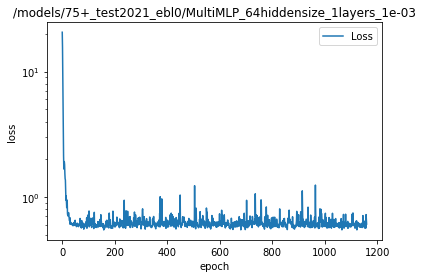

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_64hiddensize_1layers_1e-03
Train accuracy = 0.8084, Test accuracy = 0.5571
Event: Mild; Train AUC = 0.6194, Test AUC = 0.4701
Event: Severe, death; Train AUC = 0.7837, Test AUC = 0.5842
/75+_test2021_ebl0/MultiMLP_64hiddensize_2layers_1e-03
Epoch: 0, Loss: 9.0065e+00
Epoch: 100, Loss: 5.5363e-01
Epoch: 200, Loss: 5.6944e-01
Epoch: 300, Loss: 5.7000e-01
Epoch: 400, Loss: 5.8596e-01
Epoch: 500, Loss: 5.3374e-01
Epoch: 600, Loss: 5.8744e-01
Epoch: 700, Loss: 5.6789e-01
Epoch: 800, Loss: 5.8406e-01
Epoch: 900, Loss: 5.6609e-01
Epoch: 1000, Loss: 5.5581e-01
Epoch: 1100, Loss: 5.8759e-01
Epoch: 1200, Loss: 5.4178e-01
Epoch: 1300, Loss: 5.3023e-01
Epoch: 1400, Loss: 5.1554e-01
Epoch: 1500, Loss: 5.1716e-01
Epoch: 1600, Loss: 5.2996e-01
Epoch: 1700, Loss: 5.0740e-01
Epoch: 1800, Loss: 5.2281e-01
Epoch: 1900, Loss: 5.0128e-01
Epoch: 2000, Loss: 5.3909e-01
Epoch: 2100, Loss: 6.2188e-01
Epoch: 2200, Loss: 5.1384e-

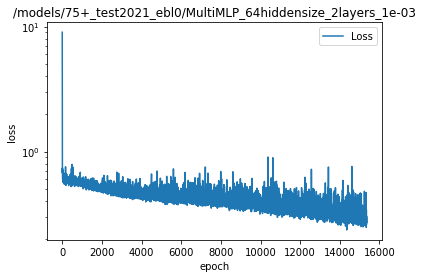

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_64hiddensize_2layers_1e-03
Train accuracy = 0.8530, Test accuracy = 0.5500
Event: Mild; Train AUC = 0.9350, Test AUC = 0.5765
Event: Severe, death; Train AUC = 0.9574, Test AUC = 0.3992
/75+_test2021_ebl0/MultiMLP_64hiddensize_3layers_1e-03
Epoch: 0, Loss: 3.1548e+00
Epoch: 100, Loss: 6.0062e-01
Epoch: 200, Loss: 5.8129e-01
Epoch: 300, Loss: 5.7232e-01
Epoch: 400, Loss: 5.9703e-01
Epoch: 500, Loss: 5.7815e-01
Epoch: 600, Loss: 5.8242e-01
Epoch: 700, Loss: 5.6386e-01
Epoch: 800, Loss: 5.4244e-01
Epoch: 900, Loss: 5.5512e-01
Epoch: 1000, Loss: 5.3594e-01
Epoch: 1100, Loss: 5.4021e-01
Epoch: 1200, Loss: 5.2558e-01
Epoch: 1300, Loss: 5.1690e-01
Epoch: 1400, Loss: 5.4676e-01
Epoch: 1500, Loss: 5.5625e-01
Epoch: 1600, Loss: 5.1583e-01
Epoch: 1700, Loss: 4.8445e-01
Epoch: 1800, Loss: 4.9221e-01
Epoch: 1900, Loss: 4.4764e-01
Epoch: 2000, Loss: 4.7571e-01
Epoch: 2100, Loss: 4.6749e-01
Epoch: 2200, Loss: 4.6203e-

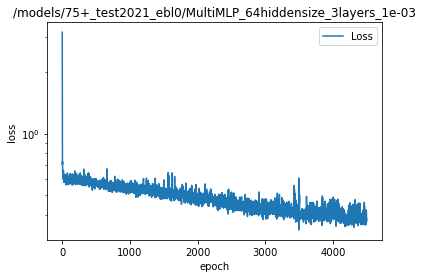

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_64hiddensize_3layers_1e-03
Train accuracy = 0.8163, Test accuracy = 0.5500
Event: Mild; Train AUC = 0.8660, Test AUC = 0.5340
Event: Severe, death; Train AUC = 0.8916, Test AUC = 0.3825
/75+_test2021_ebl0/MultiMLP_128hiddensize_1layers_1e-03
Epoch: 0, Loss: 3.7457e+00
Epoch: 100, Loss: 5.8284e-01
Epoch: 200, Loss: 5.9305e-01
Epoch: 300, Loss: 6.1035e-01
Epoch: 400, Loss: 6.3745e-01
Epoch: 500, Loss: 6.3682e-01
Epoch: 600, Loss: 6.3808e-01
Epoch: 700, Loss: 6.6530e-01
Epoch: 800, Loss: 5.9841e-01
Epoch: 900, Loss: 5.7900e-01
Epoch: 1000, Loss: 5.7535e-01
Epoch: 1100, Loss: 5.2513e-01
Epoch: 1200, Loss: 6.2299e-01


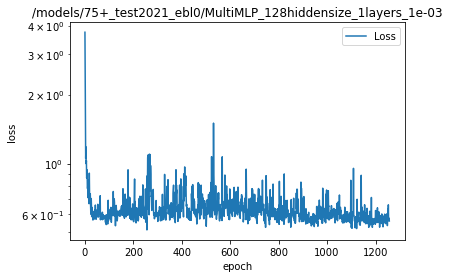

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_128hiddensize_1layers_1e-03
Train accuracy = 0.8005, Test accuracy = 0.5571
Event: Mild; Train AUC = 0.5778, Test AUC = 0.3778
Event: Severe, death; Train AUC = 0.5922, Test AUC = 0.5446
/75+_test2021_ebl0/MultiMLP_128hiddensize_2layers_1e-03
Epoch: 0, Loss: 4.1856e+00
Epoch: 100, Loss: 5.9804e-01
Epoch: 200, Loss: 5.9648e-01
Epoch: 300, Loss: 5.6301e-01
Epoch: 400, Loss: 5.7715e-01
Epoch: 500, Loss: 6.0040e-01
Epoch: 600, Loss: 5.4428e-01
Epoch: 700, Loss: 5.8325e-01
Epoch: 800, Loss: 5.6066e-01
Epoch: 900, Loss: 5.3423e-01
Epoch: 1000, Loss: 5.6083e-01
Epoch: 1100, Loss: 5.0519e-01
Epoch: 1200, Loss: 5.5191e-01
Epoch: 1300, Loss: 5.2144e-01
Epoch: 1400, Loss: 4.9832e-01
Epoch: 1500, Loss: 5.3211e-01
Epoch: 1600, Loss: 5.2102e-01
Epoch: 1700, Loss: 5.0304e-01
Epoch: 1800, Loss: 4.7243e-01
Epoch: 1900, Loss: 5.2347e-01
Epoch: 2000, Loss: 4.9089e-01
Epoch: 2100, Loss: 4.8663e-01
Epoch: 2200, Loss: 4.7504

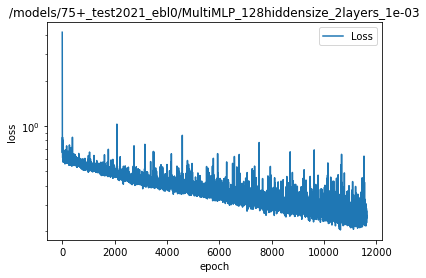

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_128hiddensize_2layers_1e-03
Train accuracy = 0.8688, Test accuracy = 0.5571
Event: Mild; Train AUC = 0.9614, Test AUC = 0.5029
Event: Severe, death; Train AUC = 0.9841, Test AUC = 0.4579
/75+_test2021_ebl0/MultiMLP_128hiddensize_3layers_1e-03
Epoch: 0, Loss: 1.6886e+00
Epoch: 100, Loss: 6.1804e-01
Epoch: 200, Loss: 6.1460e-01
Epoch: 300, Loss: 5.7892e-01
Epoch: 400, Loss: 5.6967e-01
Epoch: 500, Loss: 5.7764e-01
Epoch: 600, Loss: 5.4771e-01
Epoch: 700, Loss: 5.4079e-01
Epoch: 800, Loss: 5.9979e-01
Epoch: 900, Loss: 5.2811e-01
Epoch: 1000, Loss: 5.1705e-01
Epoch: 1100, Loss: 5.6476e-01
Epoch: 1200, Loss: 5.6603e-01
Epoch: 1300, Loss: 5.6786e-01
Epoch: 1400, Loss: 5.3082e-01
Epoch: 1500, Loss: 5.4639e-01
Epoch: 1600, Loss: 5.1831e-01
Epoch: 1700, Loss: 5.1973e-01
Epoch: 1800, Loss: 5.3997e-01
Epoch: 1900, Loss: 5.2115e-01
Epoch: 2000, Loss: 5.1975e-01
Epoch: 2100, Loss: 5.0227e-01
Epoch: 2200, Loss: 5.6254

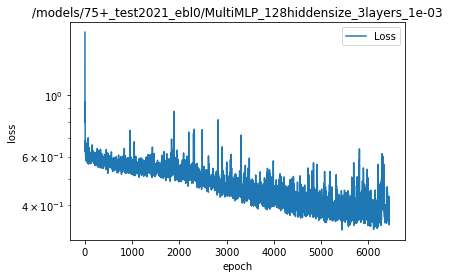

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_128hiddensize_3layers_1e-03
Train accuracy = 0.8504, Test accuracy = 0.5357
Event: Mild; Train AUC = 0.9138, Test AUC = 0.5134
Event: Severe, death; Train AUC = 0.9206, Test AUC = 0.4083
/75+_test2021_ebl0/MultiMLP_256hiddensize_1layers_1e-03
Epoch: 0, Loss: 2.4871e+00
Epoch: 100, Loss: 6.3496e-01
Epoch: 200, Loss: 6.7214e-01
Epoch: 300, Loss: 5.7221e-01
Epoch: 400, Loss: 7.1975e-01
Epoch: 500, Loss: 8.7378e-01
Epoch: 600, Loss: 6.4430e-01
Epoch: 700, Loss: 7.0993e-01
Epoch: 800, Loss: 8.1048e-01
Epoch: 900, Loss: 6.3742e-01
Epoch: 1000, Loss: 6.0556e-01
Epoch: 1100, Loss: 5.6885e-01
Epoch: 1200, Loss: 5.6923e-01
Epoch: 1300, Loss: 6.0858e-01
Epoch: 1400, Loss: 5.7340e-01
Epoch: 1500, Loss: 5.1181e-01
Epoch: 1600, Loss: 5.3603e-01
Epoch: 1700, Loss: 6.9305e-01
Epoch: 1800, Loss: 5.6021e-01
Epoch: 1900, Loss: 5.4219e-01
Epoch: 2000, Loss: 5.4924e-01
Epoch: 2100, Loss: 5.0100e-01
Epoch: 2200, Loss: 6.3425

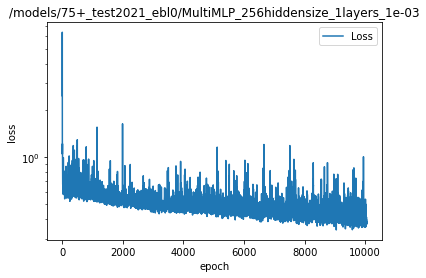

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_256hiddensize_1layers_1e-03
Train accuracy = 0.8241, Test accuracy = 0.5571
Event: Mild; Train AUC = 0.8846, Test AUC = 0.5700
Event: Severe, death; Train AUC = 0.9361, Test AUC = 0.5475
/75+_test2021_ebl0/MultiMLP_256hiddensize_2layers_1e-03
Epoch: 0, Loss: 2.3955e+00
Epoch: 100, Loss: 6.5577e-01
Epoch: 200, Loss: 6.2281e-01
Epoch: 300, Loss: 5.7855e-01
Epoch: 400, Loss: 6.3279e-01
Epoch: 500, Loss: 5.7768e-01
Epoch: 600, Loss: 5.7590e-01
Epoch: 700, Loss: 5.7552e-01
Epoch: 800, Loss: 5.5716e-01
Epoch: 900, Loss: 5.6577e-01
Epoch: 1000, Loss: 5.3480e-01
Epoch: 1100, Loss: 5.5229e-01
Epoch: 1200, Loss: 5.4288e-01
Epoch: 1300, Loss: 5.4597e-01
Epoch: 1400, Loss: 5.5529e-01
Epoch: 1500, Loss: 5.6075e-01
Epoch: 1600, Loss: 5.0182e-01
Epoch: 1700, Loss: 5.4009e-01
Epoch: 1800, Loss: 4.9716e-01
Epoch: 1900, Loss: 5.1861e-01
Epoch: 2000, Loss: 5.2115e-01
Epoch: 2100, Loss: 4.9231e-01
Epoch: 2200, Loss: 4.9638

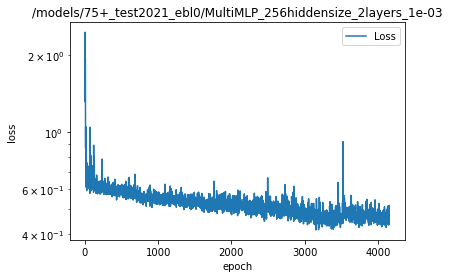

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_256hiddensize_2layers_1e-03
Train accuracy = 0.8346, Test accuracy = 0.5500
Event: Mild; Train AUC = 0.8648, Test AUC = 0.5644
Event: Severe, death; Train AUC = 0.8543, Test AUC = 0.5075
/75+_test2021_ebl0/MultiMLP_256hiddensize_3layers_1e-03
Epoch: 0, Loss: 1.7697e+00
Epoch: 100, Loss: 6.4006e-01
Epoch: 200, Loss: 5.6649e-01
Epoch: 300, Loss: 5.7651e-01
Epoch: 400, Loss: 5.9644e-01
Epoch: 500, Loss: 5.6462e-01
Epoch: 600, Loss: 5.6319e-01
Epoch: 700, Loss: 5.7324e-01
Epoch: 800, Loss: 6.0376e-01
Epoch: 900, Loss: 5.8162e-01
Epoch: 1000, Loss: 5.3000e-01
Epoch: 1100, Loss: 5.4676e-01
Epoch: 1200, Loss: 5.9309e-01
Epoch: 1300, Loss: 5.6698e-01
Epoch: 1400, Loss: 5.2318e-01
Epoch: 1500, Loss: 5.3042e-01
Epoch: 1600, Loss: 5.3665e-01
Epoch: 1700, Loss: 5.5064e-01
Epoch: 1800, Loss: 5.4073e-01
Epoch: 1900, Loss: 5.2922e-01
Epoch: 2000, Loss: 5.6061e-01
Epoch: 2100, Loss: 5.5086e-01
Epoch: 2200, Loss: 5.3149

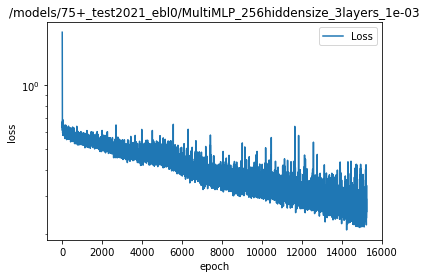

-------------------------------------------------------
/75+_test2021_ebl0/MultiMLP_256hiddensize_3layers_1e-03
Train accuracy = 0.8766, Test accuracy = 0.5286
Event: Mild; Train AUC = 0.9425, Test AUC = 0.5321
Event: Severe, death; Train AUC = 0.9608, Test AUC = 0.4375


In [32]:
criterion = nn.CrossEntropyLoss()

for weight_decay in [1e-3]:
    for hidden_size in [16, 32, 64, 128, 256]:
        for num_layer in [1, 2, 3]:
            
            path = 'D:/models/75+_test2021_ebl0/MultiMLP_{}hiddensize_{}layers_{:.0e}'.format(hidden_size, num_layer, weight_decay)
            #if os.path.isfile(path):
            #    continue
            print(path[9:])

            model = MLP(input_size=total_train.shape[-1], hidden_size=hidden_size, num_layer=num_layer, num_event=num_event).to(device)
            #if os.path.isfile(path):
            #    model.load_state_dict(torch.load(path, map_location = device))

            lr = 1e-3
            optimizer = adabound.AdaBound(model.parameters(), lr=lr, weight_decay=0)

            loss_array = []
            patience = 0
            min_loss = np.inf
            for e in range(int(1e6)):

                loss_array_tmp = []

                for total_batch, event_batch in train_loader:

                    total_batch = total_batch.float()
                    event_batch = event_batch.long()

                    y_pred = model(total_batch.to(device))

                    norm = 0.
                    for parameter in model.parameters():
                        norm += torch.norm(parameter, p=1)

                    loss1 = criterion(y_pred, event_batch.to(device))

                    loss = loss1 + weight_decay*norm
                    loss_array_tmp.append(loss1.item())

                    model.zero_grad()

                    loss.backward()

                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                loss_array.append(np.mean(loss_array_tmp))
                if e % 100 == 0:
                    print('Epoch: ' + str(e) + 
                          ', Loss: '+ f'{loss_array[-1]:.4e}')
                if min_loss > loss_array[-1]:
                    patience = 0
                    min_loss = loss_array[-1]
                    torch.save(model.state_dict(), path)
                else:
                    patience += 1

                torch.cuda.empty_cache()

                if patience > 1000:
                    break

            plt.plot(loss_array, label='Loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.yscale('log')
            plt.title(path[2:])
            plt.legend()
            plt.show()

            total_train_sort = torch.FloatTensor(total_train)
            total_test_sort = torch.FloatTensor(total_test)

            model.load_state_dict(torch.load(path, map_location = device))

            y_train = torch.softmax(model(total_train_sort.to(device)), 1).detach().cpu().numpy()
            y_test = torch.softmax(model(total_test_sort.to(device)), 1).detach().cpu().numpy()

            out_pred = np.where(y_train >= 0.5, 1, 0)
            acc_train = accuracy_score(event_train, out_pred.argmax(1))
            auc_train_mild = roc_auc_score(event_train == 1, y_train[:,1])
            auc_train_severedeath = roc_auc_score(event_train == 2, y_train[:,2])
            precision_train = precision_recall_fscore_support(event_train, out_pred.argmax(1), average='weighted')
            
            out_pred = np.where(y_test >= 0.5, 1, 0)
            acc_test = accuracy_score(event_test, out_pred.argmax(1))
            auc_test_mild = roc_auc_score(event_test == 1, y_test[:,1])
            auc_test_severedeath = roc_auc_score(event_test == 2, y_test[:,2])
            print('-------------------------------------------------------')
            print(path[9:])
            print('Train accuracy = {:.4f}, Test accuracy = {:.4f}'.format(acc_train, acc_test))
            print('Event: Mild; Train AUC = {:.4f}, Test AUC = {:.4f}'.format(auc_train_mild, auc_test_mild))
            print('Event: Severe, death; Train AUC = {:.4f}, Test AUC = {:.4f}'.format(auc_train_severedeath, auc_test_severedeath))
            print('=======================================================')